In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os,shutil

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import Sequential,Model,load_model
from keras.applications.resnet50 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import preprocess_input

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Deeplearning_final_project/Newer_correct_cqt_fft_stft/splitted_fft.zip' -d '/content/drive/MyDrive/Music/Results/FFT/'

Archive:  /content/drive/MyDrive/Deeplearning_final_project/Newer_correct_cqt_fft_stft/splitted_fft.zip
   creating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/
   creating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/
   creating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_0.png  
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_1.png  
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_2.png  
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_3.png  
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_4.png  
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_5.png  
  inflating: /content/drive/MyDrive/Music/Results/FFT/splitted_fft/train/Bach/2186_6.png  
  inflating: /content/drive/MyDrive/Mu

In [3]:
!ls
os.chdir('/content')
!ls
os.chdir('./drive/MyDrive/data/Spectra_train_test/FFT_30s_train_val_test')
!ls

drive  sample_data
drive  sample_data
aug_train  out_fft.csv	test  train  val


In [41]:
path=os.getcwd()
val_path = path + "/val"
train_path = path + "/train"

In [43]:
#image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
#VAL AND TRAIN SHOULD BE SEPERATED IN DIRECTORIES BEFOREHAND, WHEN CORRECT SPECTROGRAMS ARE OBTAINED   
#image_generator =  ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)   

image_generator =  ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input)   

#TARGET SIZES CAN BE RE-ADJUSTED TOO, WAS JUST TO TEST, SO NEED TO CHECK THIS
train_dataset = image_generator.flow_from_directory(batch_size= 25,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 #subset="training",
                                                 class_mode='categorical')

#CAREFUL HERE, BATCH_SIZES NEED TO DIVIDE TOTAL AMOUNT PERFECTLY, FOR NOW I CHANGED IT TO 1
validation_dataset = image_generator.flow_from_directory(batch_size=1,
                                                 directory=val_path, 
                                                 #subset="validation",
                                                 shuffle = False,
                                                 class_mode='categorical')

Found 3313 images belonging to 10 classes.
Found 437 images belonging to 10 classes.


In [7]:
num_classes = 10
validation_dataset.next()[0].shape

(1, 256, 256, 3)

In [44]:
#base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet", input_shape=(256,256,3))
base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(256,256,3))
# '''for layer in base_model.layers: 
#     print(layer)'''

In [46]:
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.2)
#HERE YOU CAN CHOSE EXTRA LAYERS, MAYBE POOLING EVEN, DIFFERENT ACTIVATION FUNCTION (FINAL)
flattened = keras.layers.Flatten()(base_model.output)

drop1 = dropout1(flattened)
flattened = keras.layers.Dense(512, activation='relu')(drop1)
drop2 = dropout2(flattened)
flattened = keras.layers.Dense(256, activation='relu')(drop2)

predictions = Dense(num_classes, activation = 'softmax')(flattened)
model = Model(inputs = base_model.input, outputs = predictions)

In [47]:
from tensorflow.keras.metrics import Precision, Recall
precision, recall = Precision(), Recall()

# def get_model(base_model):
#     num_classes = 10
#         # Create the dropout layers
#     dropout1 = Dropout(0.1)
#     flattened = keras.layers.Flatten()(base_model.output)
#         # Reconnect the layers
#     drop1 = dropout1(flattened)
#     #flattened = keras.layers.Dense(512, activation='relu')(flattened)
#     flattened = keras.layers.Dense(256, activation='relu')(drop1)
#     predictions = Dense(num_classes, activation = 'softmax')(flattened)
#     model = Model(inputs = base_model.input, outputs = predictions)
#     adam = Adam(lr=0.0001)
#     model = model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy', precision, recall])
#     return model

In [48]:
# #adam = Adam(lr=0.0001)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
adam = Adam(lr=0.0001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy', precision, recall])
model.summary()




Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [13]:
logs_folder = '/content/drive/MyDrive/Music/Results/FFT/logs/3/'
weights_folder = '/content/drive/MyDrive/Music/Results/FFT/weights/3/'

In [49]:

#FIT OR FIT_GENERATOR?? + CHECK WHAT BATCH SIZE DOES HERE (WHEN ALREADY WORKING WITH BATCH SIZE IN DATAGENERATOR)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime, os

# def train_model(train_dataset, validation_dataset, epochs = 50):
epochs = 50
t_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(logs_folder, t_now)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, write_graph=False)

weightdir = os.path.join(weights_folder, f"{t_now}_" + "{epoch}.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(weightdir)
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,min_delta=0.0001)



In [52]:
fft3 = model.fit(train_dataset,
    validation_data = validation_dataset,  
    epochs = epochs, workers = 10, 
    callbacks =[tensorboard_callback, stopping_callback, checkpoint,lr_callback], shuffle=True)

Epoch 1/50
133/133 [==============================] - 83s 613ms/step - loss: 0.0059 - accuracy: 0.9979 - precision_2: 0.9979 - recall_2: 0.9979 - val_loss: 1.4957 - val_accuracy: 0.8307 - val_precision_2: 0.8322 - val_recall_2: 0.8284
Epoch 2/50
133/133 [==============================] - 81s 600ms/step - loss: 0.0050 - accuracy: 0.9979 - precision_2: 0.9979 - recall_2: 0.9979 - val_loss: 1.4972 - val_accuracy: 0.8124 - val_precision_2: 0.8180 - val_recall_2: 0.8124
Epoch 3/50
133/133 [==============================] - 81s 600ms/step - loss: 0.0016 - accuracy: 0.9997 - precision_2: 0.9997 - recall_2: 0.9997 - val_loss: 1.4058 - val_accuracy: 0.8375 - val_precision_2: 0.8453 - val_recall_2: 0.8375
Epoch 4/50
133/133 [==============================] - 81s 599ms/step - loss: 0.0027 - accuracy: 0.9997 - precision_2: 0.9997 - recall_2: 0.9994 - val_loss: 1.4806 - val_accuracy: 0.8261 - val_precision_2: 0.8314 - val_recall_2: 0.8238
Epoch 5/50
133/133 [==============================] - 81s 59

In [ ]:
# mae_train_CNNmodel = mean_absolute_error(r_train_w,y_train_CNNmodel)
# mae_val_CNNmodel = mean_absolute_error(r_val_w,y_val_CNNmodel)

# print("train mae = ",mae_train_CNNmodel)
# print("validation mae = ",mae_val_CNNmodel)
# plot_history(CNN_history)


In [17]:
print("Train loss", fft3.history["loss"][-1])
print("Train accuracy",  fft3.history["accuracy"][-1])

print("Val loss", fft3.history["val_loss"][-1])
print("Val accuracy",  fft3.history["val_accuracy"][-1])

Train loss 0.06719018518924713
Train accuracy 0.9779655933380127
Val loss 1.0244044065475464
Val accuracy 0.8123570084571838


In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Music/Results/CQT/logs/'

UsageError: Line magic function `%tensorboard` not found.


In [ ]:

# #FIT OR FIT_GENERATOR?? + CHECK WHAT BATCH SIZE DOES HERE (WHEN ALREADY WORKING WITH BATCH SIZE IN DATAGENERATOR)
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6,min_delta=0.0001)
# NUM_EPOCHS = 60
# Vgg19History = model.fit(train_dataset,
#         epochs = NUM_EPOCHS, validation_data = validation_dataset, workers = 10, callbacks =[stopping_callback], shuffle=True)#, validation_steps=STEPS_PER_EPOCH_VALIDATION)#, batch_size = 256)
# # ResNetHistory = model.fit_generator(train_dataset,
# #         epochs = NUM_EPOCHS, validation_data = validation_dataset, workers = 10, callbacks =[stopping_callback], shuffle=True)#, validation_steps=STEPS_PER_EPOCH_VALIDATION)#, batch_size = 256)

In [18]:
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()
  #plt.show()



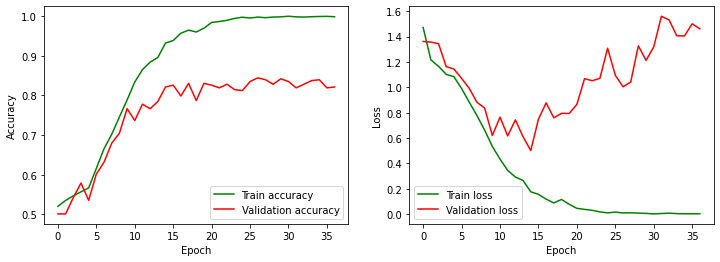

In [51]:
plot_history(fft3)

In [ ]:
fft2.history['accuracy']

[0.5278907418251038,
 0.5377687215805054,
 0.5366066098213196,
 0.5366066098213196,
 0.5395119190216064,
 0.5656595230102539,
 0.6124346256256104,
 0.6458454132080078,
 0.6804183721542358,
 0.7103428244590759,
 0.7431725859642029,
 0.7786170840263367,
 0.8172574043273926,
 0.8579314351081848,
 0.8887274861335754,
 0.9026728868484497,
 0.9189424514770508,
 0.9331783652305603,
 0.9247530698776245,
 0.9514816999435425,
 0.972980797290802,
 0.9601975679397583,
 0.9610691666603088,
 0.9697850346565247,
 0.9500290751457214,
 0.9662986397743225,
 0.9607785940170288,
 0.9825682640075684,
 0.9886693954467773]

In [ ]:
# [train_loss, train_accuracy] = model.evaluate(train_dataset, verbose=0)
# print("Training set Accuracy:{:7.2f}".format(train_accuracy))
# print("Training set Loss:{:7.4f}\n".format(train_loss))

# [val_loss, val_accuracy] = model.evaluate(validation_dataset, verbose=0)
# print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
# print("Validation set Loss:{:7.4f}\n".format(val_loss))

In [30]:
Y_pred = model.predict(validation_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 1,
       1, 1, 1, 1, 1, 9, 1, 1, 8, 1, 9, 1, 8, 1, 7, 1, 1, 1, 8, 9, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,

In [31]:
y_true = validation_dataset.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    #num_classes = 10
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names_val, rotation=45)
    plt.yticks(tick_marks, class_names_val)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
class_names_val = ['Bach', 'Beethoven', 'Brahms', 'Cambini', 'Dvorak', 'Faure', 'Haydn', 'Mozart', 'Ravel', 'Schubert']


Confusion matrix, without normalization


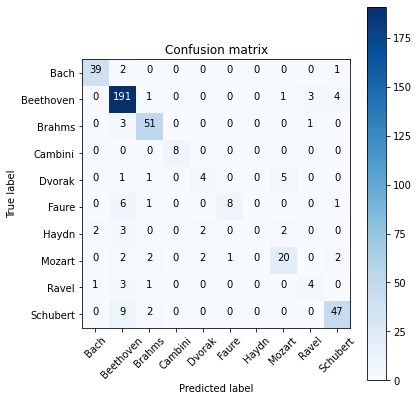

In [32]:
plot_confusion_matrix(y_true, y_pred, classes = [0,1,2,3,4,5,6,7,8,9])

In [ ]:
model.save("/content/drive/MyDrive/Music/Results/FFT/vgg19_model3_fft.h5")

In [ ]:
def plot_misclassified(ims, predictions, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    # plt.figure(figsize=((10,8)))
    f = plt.figure(figsize=(10, 8))
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        true_label = np.argmax(titles[i])
        if true_label == predictions[i]:
          continue
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(np.argmax(titles[i]), fontsize=16)
        # plt.imshow(ims[i], interpolation=None if interp else 'none')
        plt.show(ims[i], interpolation=None if interp else 'none')
        plt.savefig(path+format(i)+'.png')
        
        plt.close()
validation_dataset.reset()
for i in range(8):
  imgs, labels = validation_dataset.next()
  print(imgs.data)
  predictions = np.argmax(model.predict(imgs), axis=1)
  model.evaluate(imgs, labels)
  # plt.figure(figsize=((10,8)))
  plot_misclassified(imgs, predictions, titles=labels)
  plt.show()

1/1 [==============================] - 0s 406ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 33ms/step - loss: 0.6901 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 34ms/step - loss: 5.5894e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 37ms/step - loss: 0.0216 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 34ms/step - loss: 0.2430 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

1/1 [==============================] - 0s 35ms/step - loss: 1.1921e-07 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000


<Figure size 720x576 with 0 Axes>

In [ ]:

  # plt.close()

In [ ]:
predicted_class_indices = y_pred

labels = (validation_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_here = [labels[k] for k in predicted_class_indices]

filenames= validation_dataset.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions_here})

results.to_csv("out_fft3.csv")
!cp out_fft3.csv "/content/drive/MyDrive/Music/Results/FFT/"

filenames_split = filenames[0].split("/")

In [ ]:
data = []
for i in range(len(predictions_here)):
  filenames_split = filenames[i].split("/")
  composer = filenames_split[-2]
  full_info = (filenames_split[-1])[:-4].split("_")
  piece = full_info[0]
  part = full_info[1]
  pred = predictions_here[i]

  data.append([composer, piece, part, pred])

results2 = pd.DataFrame(data, columns = ["Composer","Piece", "Part", "Prediction"])

In [ ]:
#FOR PLOTS ON WHICH PARTS OF WHICH COMPOSERS IS WRONG, TO BE FINISHED
results2.Part = results2.Part.astype(int)
X = results2.sort_values(by=["Part"])
K = X.groupby("Piece")

composer_intro = {}
composer_middle = {}
composer_outro = {}
composer_pieces = {}
composer_songs = {}


for x in class_names_val:
  composer_intro[x] = 0
  composer_middle[x] = 0
  composer_outro[x] = 0
  composer_pieces[x] = 0
  composer_songs[x] = 0

print(composer_songs)
count = 0
groups = dict(list(K))
for x in groups:
  cur_group = groups[x]
  length_here = len(cur_group)

  composer_here = cur_group["Composer"].unique()[0]

  composer_pieces[composer_here] = composer_pieces[composer_here]  + length_here
  composer_songs[composer_here] = composer_songs[composer_here] + 1

  all_wrong = cur_group.where(cur_group["Composer"] != cur_group["Prediction"]).count()[0]
  intro_wrong = cur_group.where((cur_group["Composer"] != cur_group["Prediction"]) & (cur_group["Part"] == 0)).count()[0]
  outro_wrong = cur_group.where((cur_group["Composer"] != cur_group["Prediction"]) & (cur_group["Part"] == length_here - 1)).count()[0]

  composer_intro[composer_here] = composer_intro[composer_here] + intro_wrong
  composer_middle[composer_here] = composer_middle[composer_here] + all_wrong - intro_wrong - outro_wrong
  composer_outro[composer_here] = composer_outro[composer_here] + outro_wrong

for x in class_names_val:
  print("-----------------------------------")
  songs = composer_songs[x]
  parts = composer_pieces[x]

  wrong_intro = composer_intro[x]
  wrong_outro = composer_outro[x]
  wrong_middle = composer_middle[x]

  middle_wrong_total = ((wrong_middle)/(parts - (2*songs)))*100

  print("For Composer " + x + " with a total of " + str(songs) + "songs:")
  print("Which consists of a total of " + str(composer_pieces[x]) + " pieces (=spectrograms)")
  print(str(wrong_intro) + " intro's are wrong (or in percentage): " + str((wrong_intro/songs)*100))
  print(str(wrong_outro) + " outro's are wrong (or in percentage): " + str((wrong_outro/songs)*100))
  print(str(wrong_middle) + " middle parts are wrong (or in percentage): " + str(middle_wrong_total))

{'Bach': 0, 'Beethoven': 0, 'Brahms': 0, 'Cambini': 0, 'Dvorak': 0, 'Faure': 0, 'Haydn': 0, 'Mozart': 0, 'Ravel': 0, 'Schubert': 0}
-----------------------------------
For Composer Bach with a total of 7songs:
Which consists of a total of 23 pieces (=spectrograms)
2 intro's are wrong (or in percentage): 28.57142857142857
1 outro's are wrong (or in percentage): 14.285714285714285
1 middle parts are wrong (or in percentage): 11.11111111111111
-----------------------------------
For Composer Beethoven with a total of 16songs:
Which consists of a total of 228 pieces (=spectrograms)
0 intro's are wrong (or in percentage): 0.0
0 outro's are wrong (or in percentage): 0.0
0 middle parts are wrong (or in percentage): 0.0
-----------------------------------
For Composer Brahms with a total of 3songs:
Which consists of a total of 42 pieces (=spectrograms)
1 intro's are wrong (or in percentage): 33.33333333333333
0 outro's are wrong (or in percentage): 0.0
4 middle parts are wrong (or in percentag